In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install h5py==2.10.0

  Using cached h5py-2.10.0.tar.gz (301 kB)
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for h5py
  Running setup.py clean for h5py
Failed to build h5py
ERROR: Could not build wheels for h5py, which is required to install pyproject.toml-based projects


In [ ]:
import tensorflow as tf
print("tensorflow version :{}".format(tf.__version__))
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

tensorflow version :2.15.0
Found GPU at: /device:GPU:0


In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 9453664068473440604
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14626652160
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 18351971974102832141
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

In [ ]:
#### physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.utils import class_weight

In [ ]:

from keras.layers import Conv2D, Dense, Dropout, GlobalMaxPooling2D, Reshape
from keras.layers import TimeDistributed, LSTM, Bidirectional, Input, concatenate,RepeatVector
from keras import regularizers
# from keras.layers.normalization import BatchNormalization
from keras.models import Sequential, load_model, Model
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from tensorflow.keras.utils import plot_model, to_categorical
from keras.losses import binary_crossentropy
from keras.optimizers import Adam
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix
from keras.regularizers import l1,l2


In [ ]:
data_path = '/content/drive/MyDrive/CAV/data/Instant attack/25/'

In [ ]:
sensor1_data = pd.read_csv(data_path + "Sensor1_values_instant_25.csv", index_col= 'Unnamed: 0')
sensor1_data.head()

,InVehicle_Longitudinal_Speed,GPS_Speed,InVehicle_Longitudinal_Accel
0,11.375000,11.307097,-0.103000
1,11.366708,11.255964,-0.353946
2,11.362331,11.249115,-0.090962
3,11.358665,11.263280,-0.043470
4,11.356745,11.270361,-0.037579


In [ ]:
sensor1_data

,InVehicle_Longitudinal_Speed,GPS_Speed,InVehicle_Longitudinal_Accel
0,11.375000,11.307097,-0.103000
1,11.366708,11.255964,-0.353946
2,11.362331,11.249115,-0.090962
3,11.358665,11.263280,-0.043470
4,11.356745,11.270361,-0.037579
...,...,...,...
29795,22.855765,22.834129,-0.081526
29796,22.858710,22.840796,-0.034917
29797,22.862361,22.826919,0.009582
29798,22.865025,22.827342,0.021096


In [ ]:
sensor1_label = pd.read_csv(data_path+"Ground_truth_instant_25_sensor1.csv", names=['Class'])
sensor1_label.head()

,Class
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


In [ ]:
sensor1_label

,Class
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
29795,0.0
29796,0.0
29797,0.0
29798,0.0


In [ ]:
len(sensor1_label)

29800

In [ ]:
print(min(sensor1_data['InVehicle_Longitudinal_Speed']))
print(max(sensor1_data['InVehicle_Longitudinal_Speed']))

-0.578392961
26.02790171


In [ ]:
print(min(sensor1_data['GPS_Speed']))
print(max(sensor1_data['GPS_Speed']))

-0.371344948
26.02050124


In [ ]:
print(min(sensor1_data['InVehicle_Longitudinal_Accel']))
print(max(sensor1_data['InVehicle_Longitudinal_Accel']))

-3.034234538
2.535557857


In [ ]:
sensor2_data = pd.read_csv(data_path + "Sensor2_values_instant_25.csv", index_col = "Unnamed: 0")
sensor2_data.head()

,InVehicle_Longitudinal_Speed,GPS_Speed,InVehicle_Longitudinal_Accel
0,11.375000,11.307097,-0.103000
1,11.366708,11.255964,-0.353946
2,11.362331,11.249115,-0.090962
3,11.358665,11.263280,-0.043470
4,11.356745,11.270361,-0.037579


In [ ]:
sensor2_label = pd.read_csv(data_path + "Ground_truth_instant_25_sensor2.csv",names=['Class'])
sensor2_label.head()

,Class
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


In [ ]:
print(min(sensor2_data['InVehicle_Longitudinal_Speed']))
print(max(sensor2_data['InVehicle_Longitudinal_Speed']))

-0.345859131
26.1544618


In [ ]:
print(min(sensor2_data['GPS_Speed']))
print(max(sensor2_data['GPS_Speed']))

-0.385830815
26.02050124


In [ ]:
print(min(sensor2_data['InVehicle_Longitudinal_Accel']))
print(max(sensor2_data['InVehicle_Longitudinal_Accel']))

-3.034234538
2.484012412


In [ ]:
sensor3_data = pd.read_csv(data_path + "Sensor3_values_instant_25.csv", index_col = "Unnamed: 0")
sensor3_data.head()

,InVehicle_Longitudinal_Speed,GPS_Speed,InVehicle_Longitudinal_Accel
0,11.375000,11.307097,-0.103000
1,11.366708,11.255964,-0.353946
2,11.362331,11.249115,-0.090962
3,11.358665,11.263280,-0.043470
4,11.356745,11.270361,-0.037579


In [ ]:
sensor3_label = pd.read_csv(data_path + "Ground_truth_instant_25_sensor3.csv", names=['Class'])
sensor3_label.head()

,Class
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


In [ ]:
print(min(sensor3_data['InVehicle_Longitudinal_Speed']))
print(max(sensor3_data['InVehicle_Longitudinal_Speed']))

-0.345859131
26.1544618


In [ ]:
print(min(sensor2_data['GPS_Speed']))
print(max(sensor2_data['GPS_Speed']))

-0.385830815
26.02050124


In [ ]:
print(min(sensor2_data['InVehicle_Longitudinal_Accel']))
print(max(sensor2_data['InVehicle_Longitudinal_Accel']))

-3.034234538
2.484012412


In [ ]:
scaler = StandardScaler()
scaler.fit(sensor1_data)
sensor1_data_normal = scaler.transform(sensor1_data)
sensor1_data_normal[:5]

array([[-0.43462791, -0.46087155, -0.13104562],
       [-0.43574455, -0.46783173, -0.5025529 ],
       [-0.43633402, -0.46876392, -0.11322419],
       [-0.43682777, -0.46683584, -0.04291596],
       [-0.43708629, -0.46587195, -0.03419428]])

In [ ]:
sensor1_data_normal

array([[-0.43462791, -0.46087155, -0.13104562],
       [-0.43574455, -0.46783173, -0.5025529 ],
       [-0.43633402, -0.46876392, -0.11322419],
       ...,
       [ 1.11239628,  1.10718145,  0.03562447],
       [ 1.1127551 ,  1.10723906,  0.05266925],
       [ 1.11311802,  1.1024623 ,  0.06510927]])

In [ ]:
len(sensor1_data_normal)

29800

In [ ]:
scaler = StandardScaler()
scaler.fit(sensor2_data)
sensor2_data_normal = scaler.transform(sensor2_data)
sensor2_data_normal[:5]

array([[-0.4346299 , -0.46085105, -0.13143903],
       [-0.43574651, -0.46781088, -0.50274163],
       [-0.43633598, -0.46874303, -0.11362742],
       [-0.43682972, -0.46681505, -0.04335792],
       [-0.43708823, -0.4658512 , -0.03464105]])

In [ ]:
scaler = StandardScaler()
scaler.fit(sensor3_data)
sensor3_data_normal = scaler.transform(sensor3_data) #
sensor3_data_normal[:5]

array([[-0.4346299 , -0.46085105, -0.13143903],
       [-0.43574651, -0.46781088, -0.50274163],
       [-0.43633598, -0.46874303, -0.11362742],
       [-0.43682972, -0.46681505, -0.04335792],
       [-0.43708823, -0.4658512 , -0.03464105]])

In [ ]:
window_size = 10

# create windows with overlap
def convertToFrames(X_data,y_data, step):
    X, Y =[], []
    for i in range(len(X_data)-step):
        y_or = 0
        d=i+step
        X.append(X_data[i:d,])
        for y in y_data.iloc[i:d].values:
           y_or = y_or or y

        Y.append(y_or)
    return np.array(X), np.array(Y)

In [ ]:
X_sensor1, y_sensor1 = convertToFrames(sensor1_data_normal, sensor1_label, window_size)
X_sensor1.shape, y_sensor1.shape
# print(X_sensor1[0])
# print(X_sensor1[1])

((29790, 10, 3), (29790, 1))

In [ ]:
X_sensor1

array([[[-0.43462791, -0.46087155, -0.13104562],
        [-0.43574455, -0.46783173, -0.5025529 ],
        [-0.43633402, -0.46876392, -0.11322419],
        ...,
        [-0.43859425, -0.46951288,  0.10616898],
        [-0.43955858, -0.47140223, -0.03259014],
        [-0.44015153, -0.47209672, -0.05940621]],

       [[-0.43574455, -0.46783173, -0.5025529 ],
        [-0.43633402, -0.46876392, -0.11322419],
        [-0.43682777, -0.46683584, -0.04291596],
        ...,
        [-0.43955858, -0.47140223, -0.03259014],
        [-0.44015153, -0.47209672, -0.05940621],
        [-0.44068282, -0.47222054, -0.11780799]],

       [[-0.43633402, -0.46876392, -0.11322419],
        [-0.43682777, -0.46683584, -0.04291596],
        [-0.43708629, -0.46587195, -0.03419428],
        ...,
        [-0.44015153, -0.47209672, -0.05940621],
        [-0.44068282, -0.47222054, -0.11780799],
        [-0.44147438, -0.47071955, -0.09806168]],

       ...,

       [[ 1.11262699,  1.10921194,  0.01565418],
        [ 1

In [ ]:
len(X_sensor1)

29790

In [ ]:
X_sensor2, y_sensor2 = convertToFrames(sensor2_data_normal, sensor2_label, window_size)
X_sensor2.shape, y_sensor2.shape

((29790, 10, 3), (29790, 1))

In [ ]:
X_sensor3, y_sensor3 = convertToFrames(sensor3_data_normal, sensor3_label, window_size)
X_sensor3.shape, y_sensor3.shape

((29790, 10, 3), (29790, 1))

In [ ]:
y_sensor3

array([[1.],
       [1.],
       [1.],
       ...,
       [0.],
       [0.],
       [0.]])

In [ ]:
y_sensor1 = to_categorical(y_sensor1, num_classes= 2, dtype='float32')
y_sensor1

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [ ]:
y_sensor1.shape

(29790, 2)

In [ ]:
y_sensor2 = to_categorical(y_sensor2, num_classes= 2, dtype='float32')

In [ ]:
y_sensor3 = to_categorical(y_sensor3, num_classes= 2, dtype='float32')

In [ ]:
y_sensor1.shape, y_sensor2.shape, y_sensor3.shape

((29790, 2), (29790, 2), (29790, 2))

In [ ]:
y_sensor1 = [np.argmax(i) for i in y_sensor1]
y_sensor2 = [np.argmax(i) for i in y_sensor2]
y_sensor3 = [np.argmax(i) for i in y_sensor3]

In [ ]:
y_sensors = []
for i in range(len(y_sensor1)):
  y_sensors.append(y_sensor1[i] or y_sensor2[i] or y_sensor3[i])

In [ ]:
y_sensors = to_categorical(y_sensors, num_classes= 2, dtype='float32')
y_sensors.shape

(29790, 2)

In [ ]:
X_sensors = np.concatenate((X_sensor1,X_sensor2,X_sensor3),axis=1)


In [ ]:
X_sensors.shape

(29790, 30, 3)

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
n_splits = 10
tscv = TimeSeriesSplit(n_splits=n_splits)
for train_index, test_index in tscv.split(X_sensors):
    # Split the data based on the indices
    X_train_sensors, X_test_sensors = X_sensors[train_index], X_sensors[test_index]
    y_train_sensors, y_test_sensors = y_sensors[train_index], y_sensors[test_index]


In [ ]:
X_train_sensors.shape, X_test_sensors.shape, y_train_sensors.shape, y_test_sensors.shape

((27082, 30, 3), (2708, 30, 3), (27082, 2), (2708, 2))

In [ ]:

def creatModel():

    model = Sequential()
    model.add(Conv2D(filters=40, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(X_train_sensors.shape[1], X_train_sensors.shape[2], 1)))
    model.add(Dropout(0.1))
    model.add(Conv2D(filters=60, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(Dropout(0.1))
    #model.add(Conv2D(filters=60, kernel_size=(3, 3), activation='relu', padding='same'))
    #model.add(Dropout(0.1))
    model.add(GlobalMaxPooling2D())
    model.add(RepeatVector(X_train_sensors.shape[1]))
    model.add(LSTM(256, return_sequences=False))
    model.add(Dropout(rate=0.2))
    #model.add(LSTM(128, return_sequences=True))
    #model.add(Dropout(rate=0.2))
    #model.add(LSTM(64, return_sequences=False))
    #model.add(Dropout(rate=0.2))
    model.add(Dense(32))
    model.add(Dense(16))
    model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2()))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
import time

class TimeHistory(Callback):

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        epoch_time = time.time() - self.epoch_time_start
        logs['epoch_time'] = epoch_time


In [ ]:
# Function to calculate prediction time
def calculate_prediction_time(model, X_data):
    start_time = time.time()
    predictions = model.predict(X_data)
    end_time = time.time()
    prediction_time = end_time - start_time
    return prediction_time, predictions


In [ ]:
model_path = '/content/drive/MyDrive/CAV/data/Instant attack/25/Models/Models14-6-2DCNN-40-60-LSTM-256/'

class Model_save(Callback):
  def on_epoch_end(self, epoch, logs={}):
    self.model.save(model_path + "CNN-LSTM-autoEncoder-Instant-25-CAV-perEpoch_{}.h5".format(sensor))


In [ ]:
def setCallbacks(sensor):

  best_model_path = model_path + 'Best_CNN-LSTM-autoEncoder-Instant-25-CAV_{}.h5'.format(sensor)
  checkpoint = ModelCheckpoint(best_model_path, monitor='val_loss', save_best_only=True, mode='min')

  history_cb = tf.keras.callbacks.CSVLogger(model_path + 'historyLOG_Instant-25_{}.csv'.format(sensor), separator=",", append=True)

  model_save = Model_save()

  Estop = EarlyStopping(monitor='val_accuracy', patience= 300)

  return model_save, checkpoint, history_cb, Estop

In [ ]:
sensor = "sensors"
time_callback = TimeHistory()
model_sensors = creatModel()
model_save, checkpoint, history_cb, Estop = setCallbacks("sensors")
history_sensors = model_sensors.fit(X_train_sensors, y_train_sensors,
                                    batch_size = 128, epochs = 500,
                                    validation_split = 0.1,
                                    verbose = 1,
                                    callbacks = [time_callback, model_save, checkpoint, history_cb, Estop])
                                    # class_weight= class_weights)#


Epoch 1/500
191/191 [==============================] - 13s 14ms/step - loss: 0.6955 - accuracy: 0.5920 - val_loss: 0.6954 - val_accuracy: 0.5666 - epoch_time: 12.6743
Epoch 2/500
  1/191 [..............................] - ETA: 2s - loss: 0.6883 - accuracy: 0.5938

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


191/191 [==============================] - 2s 11ms/step - loss: 0.6778 - accuracy: 0.5966 - val_loss: 0.6730 - val_accuracy: 0.6091 - epoch_time: 1.8489
Epoch 3/500
191/191 [==============================] - 2s 12ms/step - loss: 0.6604 - accuracy: 0.6226 - val_loss: 0.6656 - val_accuracy: 0.6213 - epoch_time: 2.1896
Epoch 4/500
191/191 [==============================] - 2s 12ms/step - loss: 0.6481 - accuracy: 0.6336 - val_loss: 0.6695 - val_accuracy: 0.6250 - epoch_time: 2.2147
Epoch 5/500
191/191 [==============================] - 2s 10ms/step - loss: 0.6380 - accuracy: 0.6455 - val_loss: 0.6527 - val_accuracy: 0.6346 - epoch_time: 1.6883
Epoch 6/500
191/191 [==============================] - 2s 11ms/step - loss: 0.6327 - accuracy: 0.6495 - val_loss: 0.6852 - val_accuracy: 0.6161 - epoch_time: 2.0123
Epoch 7/500
191/191 [==============================] - 3s 15ms/step - loss: 0.6313 - accuracy: 0.6517 - val_loss: 0.6643 - val_accuracy: 0.6298 - epoch_time: 2.7728
Epoch 8/500
191/191 [=

In [ ]:
model_sensors = load_model(model_path + "CNN-LSTM-autoEncoder-Instant-25-CAV-perEpoch_sensors.h5")

In [ ]:
print(model_sensors.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 30, 3, 40)         400       
                                                                 
 dropout_3 (Dropout)         (None, 30, 3, 40)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 30, 3, 60)         21660     
                                                                 
 dropout_4 (Dropout)         (None, 30, 3, 60)         0         
                                                                 
 global_max_pooling2d_1 (Gl  (None, 60)                0         
 obalMaxPooling2D)                                               
                                                                 
 repeat_vector_1 (RepeatVec  (None, 30, 60)            0         
 tor)                                                 

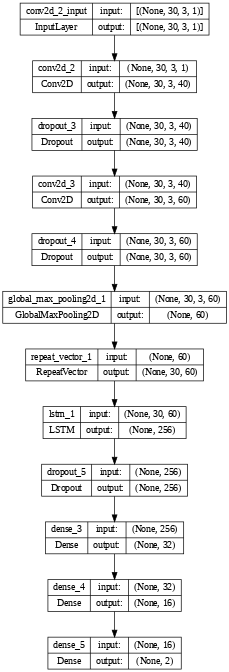

In [ ]:
plot_model(model= model_sensors, show_shapes= True, dpi=50)

In [ ]:
# Calculate prediction time for sensor1
prediction_time_sensors, _ = calculate_prediction_time(model_sensors, X_test_sensors)
print(f'Prediction time for sensors: {prediction_time_sensors} seconds')

85/85 [==============================] - 1s 5ms/step
Prediction time for sensors: 1.4334640502929688 seconds


In [ ]:
#plot history of model_sensor1
history_sensors = pd.read_csv(model_path +"historyLOG_Instant-25_sensors.csv", index_col='epoch')
history_sensors.reset_index(drop= True, inplace= True)
history_sensors.head()
print('Average Exe_time for sensors: {} sec.'.format(round(np.mean(history_sensors['epoch_time'].values),3)))


Average Exe_time for sensors: 1.99 sec.


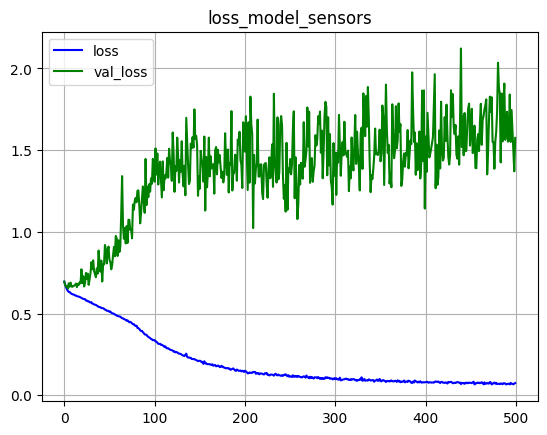

In [ ]:
plt.plot( history_sensors['loss'], 'b',label = 'loss')
plt.plot( history_sensors['val_loss'], 'g', label = 'val_loss')
plt.legend()
plt.grid()
plt.title('loss_model_sensors')
plt.show()

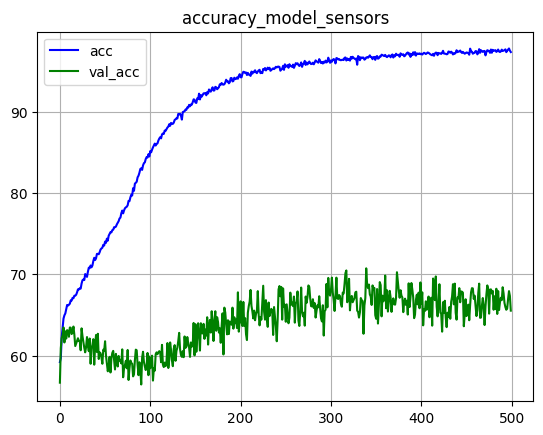

In [ ]:
plt.plot(history_sensors['accuracy']* 100,'b',label = 'acc')
plt.plot(history_sensors['val_accuracy'] * 100,'g', label = 'val_acc')
plt.legend()
plt.grid()
plt.title('accuracy_model_sensors')
plt.show()

In [ ]:
#last model_sensor1 evaluation
test_loss, test_acc = model_sensors.evaluate( X_test_sensors, y_test_sensors, verbose= 1)
print('test accuracy :{:.1%} \n test loss :{:.3}'.format(test_acc, test_loss))

85/85 [==============================] - 1s 4ms/step - loss: 1.3201 - accuracy: 0.7278
test accuracy :72.8% 
 test loss :1.32


In [ ]:
y_pred_total = model_sensors.predict( X_test_sensors, verbose= 1)

85/85 [==============================] - 0s 3ms/step


In [ ]:
y_pred_total = [np.argmax(i) for i in y_pred_total]
y_pred_total

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [ ]:
y_test_sensors

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [ ]:
y_test_sensors = [np.argmax(i) for i in y_test_sensors]
y_test_sensors

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [ ]:
y_pred_total

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [ ]:
print("All Sensors performanace:\n")

recall = recall_score(y_test_sensors, y_pred_total, average='micro')
print('recall score : {:.2%}\n'.format(recall ))

precision = precision_score(y_test_sensors, y_pred_total, average='micro')
print('precision score: {:.2%}\n'.format(precision ))

f1 = f1_score(y_test_sensors, y_pred_total, average='micro')
print("F1 score: {:.2%}\n".format(f1 ))

accuracy = accuracy_score(y_test_sensors, y_pred_total)
print("accuracy score: {:.2%}\n".format(accuracy))

All Sensors performanace:

recall score : 72.78%

precision score: 72.78%

F1 score: 72.78%

accuracy score: 72.78%



In [ ]:
print("All Sensors performanace:\n")

recall = recall_score(y_test_sensors, y_pred_total, average='macro')
print('recall score : {:.2%}\n'.format(recall ))

precision = precision_score(y_test_sensors, y_pred_total, average='macro')
print('precision score: {:.2%}\n'.format(precision ))

f1 = f1_score(y_test_sensors, y_pred_total, average='macro')
print("F1 score: {:.2%}\n".format(f1 ))

accuracy = accuracy_score(y_test_sensors, y_pred_total)
print("accuracy score: {:.2%}\n".format(accuracy))

All Sensors performanace:

recall score : 66.76%

precision score: 73.14%

F1 score: 67.35%

accuracy score: 72.78%



In [ ]:
conf = confusion_matrix(y_test_sensors, y_pred_total, labels=[1,0])
conf_df = pd.DataFrame(conf, columns= [1,0], index= [1,0])
conf_df

,1,0
1,433,583
0,154,1538
